In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from configs import configs
from utils import legend_without_duplicate_labels, generate_isometric_input
from model import TransformerModel
import pandas as pd
import math
from pathlib import Path
from matplotlib import cm, colormaps
from matplotlib.colors import LinearSegmentedColormap



In [2]:
myplot = lambda x,y,ms,col,ax: ax.scatter(x,y, s=ms*2, edgecolors="k", c=col, linewidths=2)


In [3]:
#config_name = 'A(X) + upscaled skip'
config_name = 'A(X)'
#config_name = '$A(X)^{\perp}$'


model_params = configs[config_name]

n_layers = 10
seq_length = 200
gamma = 1
X0 = generate_isometric_input(seq_length)
X0 = X0.reshape(1, X0.shape[0], X0.shape[1])

model = TransformerModel(
    n_layers,
    seq_length,
    gamma,
    heads=model_params.get("heads"),
    attention_type=model_params.get("attention_type"),
    distribution_A=model_params.get("distribution_A"),
    #distribution_V=model_params.get("distribution_V"),
    distribution_V="identity",
    LN=model_params.get("layernorm"),
    skip_connections=model_params.get("skip_connections"),
    sigma_A=model_params.get("sigma_A"),
    sigma_V=model_params.get("sigma_V"),
    mlp=model_params.get("mlp"),
    #distribution_Q=model_params.get("distribution_Q"),
    #distribution_K=model_params.get("distribution_K"),
    distribution_Q="normal",
    distribution_K="normal"
)

## forward pass
output, embeddings = model.forward_with_embeds(X0)

/tmp/ipykernel_1940520/2782444142.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


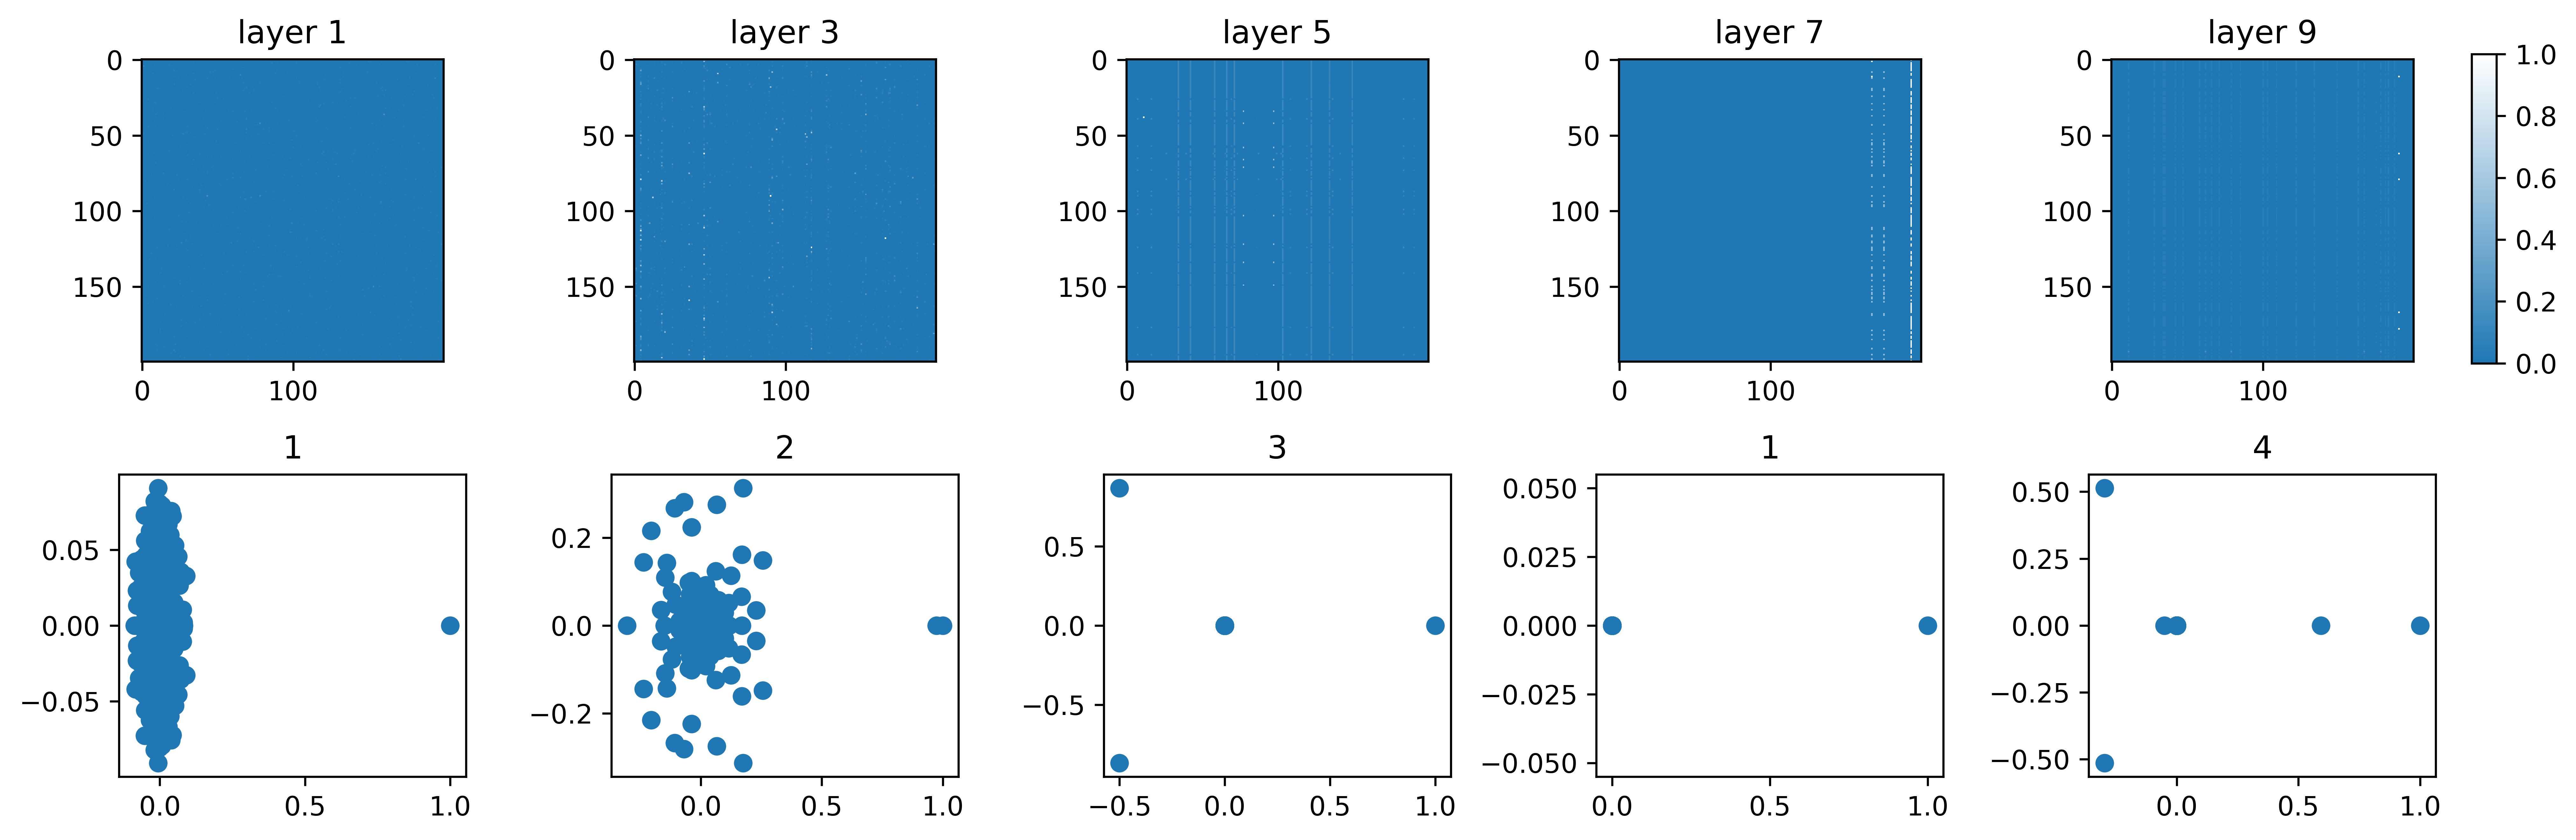

In [9]:
X_2d = np.random.randn(2,seq_length)*.3

p = 2
#fig_queries, axs_queries = plt.subplots(1, n_layers//p, figsize=(25,2), dpi=600)
#fig_keys, axs_keys = plt.subplots(1, n_layers//p, figsize=(25,2), dpi=600)

fig1, axs1 = plt.subplots(2, n_layers//p, figsize=(13,4.5), dpi=600)
#fig2, axs2 = plt.subplots(1, n_layers//p, figsize=(25,2), dpi=600)
#fig3, axs3 = plt.subplots(1, n_layers//p, figsize = (25,3), dpi=600)

list_attentions = []
list_evals_attention = []
cmap = LinearSegmentedColormap.from_list('blues', [colormaps['Paired'].colors[1], 'white'] , N=100)


X = X0  # embeddings[0]=X1

for i in range(0,n_layers//p):
    l = p * i
    if '(X)' in config_name:
        keys = model.blocks[l].multi_head_attention.attention.key_embed(X)
        queries = model.blocks[l].multi_head_attention.attention.query_embed(X)
        #axs_queries[i].imshow(queries.detach().numpy().reshape(seq_length, seq_length), vmin=0, vmax=1,interpolation='nearest')
        #axs_keys[i].imshow(keys.detach().numpy().reshape(seq_length, seq_length), vmin=0, vmax=1,interpolation='nearest')
        #axs_queries[i].axis('off')
        #axs_keys[i].axis('off')


    else:
        keys, queries = 0, 0
    
    A = (model.blocks[l].multi_head_attention.attention.get_attention_weights(queries, keys)).detach().numpy().reshape(seq_length, seq_length)
    list_attentions.append(A)
    if model.blocks[l].multi_head_attention.attention.distribution_A == "chafai_perp":
        A = A - 1/seq_length * np.ones((seq_length,seq_length))
    
    e_vals = np.linalg.eigvals(A)
    list_evals_attention.append(e_vals)
    X = embeddings[l]
    nb_connected_components = (np.abs(e_vals) >0.5 ).sum()

    im = axs1[0,i].imshow(A, vmin=0, vmax=1,interpolation='nearest', cmap=cmap)
    axs1[0,i].set_title(f'layer {l+1}')

    #axs1[0,i].axis('off')
    axs1[1,i].scatter(np.real(e_vals), np.imag(e_vals), color=colormaps['Paired'].colors[1])
    axs1[1,i].set_title(nb_connected_components)


    a = 1/seq_length * np.ones(seq_length)
    #X_2d = X[0,:,:2].T.detach().numpy()

    #c = 1
    #I,J = np.nonzero(list_attentions[i] > 1e-5)
    #for k in range(len(I)):
    #    h = axs3[i].plot(np.hstack((X_2d[0,I[k]],X_2d[0,J[k]])),np.hstack(([X_2d[1,I[k]], X_2d[1,J[k]]])),'k', lw = list_attentions[i][I[k],J[k]])
    #for j in range(len(a)):
    #    myplot(X_2d[0,j], X_2d[1,j], a[j]*len(a)*2, 'r', axs3[i])
    #axs3[i].set_xlim(np.min(X_2d[0,:])-.1,np.max(X_2d[0,:])+.1)
    #axs3[i].set_ylim(np.min(X_2d[1,:])-.1,np.max(X_2d[1,:])+.1)
    #axs3[i].axis("off")
    #axs2[l].set_ylim(-1.1, 1.1)

fig1.subplots_adjust(right=0.84)
cbar_ax = fig1.add_axes([1.0, 0.566, 0.01, 0.355])
fig1.colorbar(im, cax=cbar_ax, cmap=cmap)
#fig1.colorbar(im, cmap=cm.PuBu_r)

#plt.suptitle(config_name)
#if '(X)' in config_name:
#    fig_keys.show()
#    fig_queries.show()

fig1.tight_layout()
directory_output_path = Path(Path().absolute()) / "figs"  / "attention"
directory_output_path.mkdir(exist_ok=True, parents=True)
fig1.savefig(directory_output_path/ f'{config_name}.pdf', dpi=600, bbox_inches = 'tight')
#fig2.savefig(directory_output_path/'test2.pdf', dpi=300)

#fig1.show()
#fig2.show()
#fig3.show()
